## Contents

1. [Introduction](#1)
2. [Pre-Processing for Baseline](#2)
3. [Baseline Model](#3)

## Introduction <a></a>

This notebook will document my new project to learn NLP, using the Quora Insincere Questions data source. I am attempting the challenge after the competition deadline has already passed, but in a Kaggle Kernel. After completing the project, I will download it and push to my Github repo.

This notebook will begin with pre-processing and building a quick baseline model, using TF-IDF with logistic regression. Then I will peform some slightly different pre-processing for word embeddings (following advice from experienced kagglers) and then build an LSTM model.

In [1]:
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
train_set = pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test_set = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")

## EDA

In [3]:
print("Train shape : ",train_set.shape)
print("Test shape : ",test_set.shape)

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


In [4]:
train_set.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [5]:
train_set['target'].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

Looking at some examples of positive and negative questions. The non-toxic questions are definitely the normal curious questions. The insincere questions look a bit random and seem written by weird people.

In [6]:
train_set.query('target==0')['question_text'].head()

0    How did Quebec nationalists see their province...
1    Do you have an adopted dog, how would you enco...
2    Why does velocity affect time? Does velocity a...
3    How did Otto von Guericke used the Magdeburg h...
4    Can I convert montra helicon D to a mountain b...
Name: question_text, dtype: object

In [7]:
train_set.query('target==1')['question_text'].head()

22     Has the United States become the largest dicta...
30     Which babies are more sweeter to their parents...
110    If blacks support school choice and mandatory ...
114    I am gay boy and I love my cousin (boy). He is...
115                 Which races have the smallest penis?
Name: question_text, dtype: object

Wordcloud plot

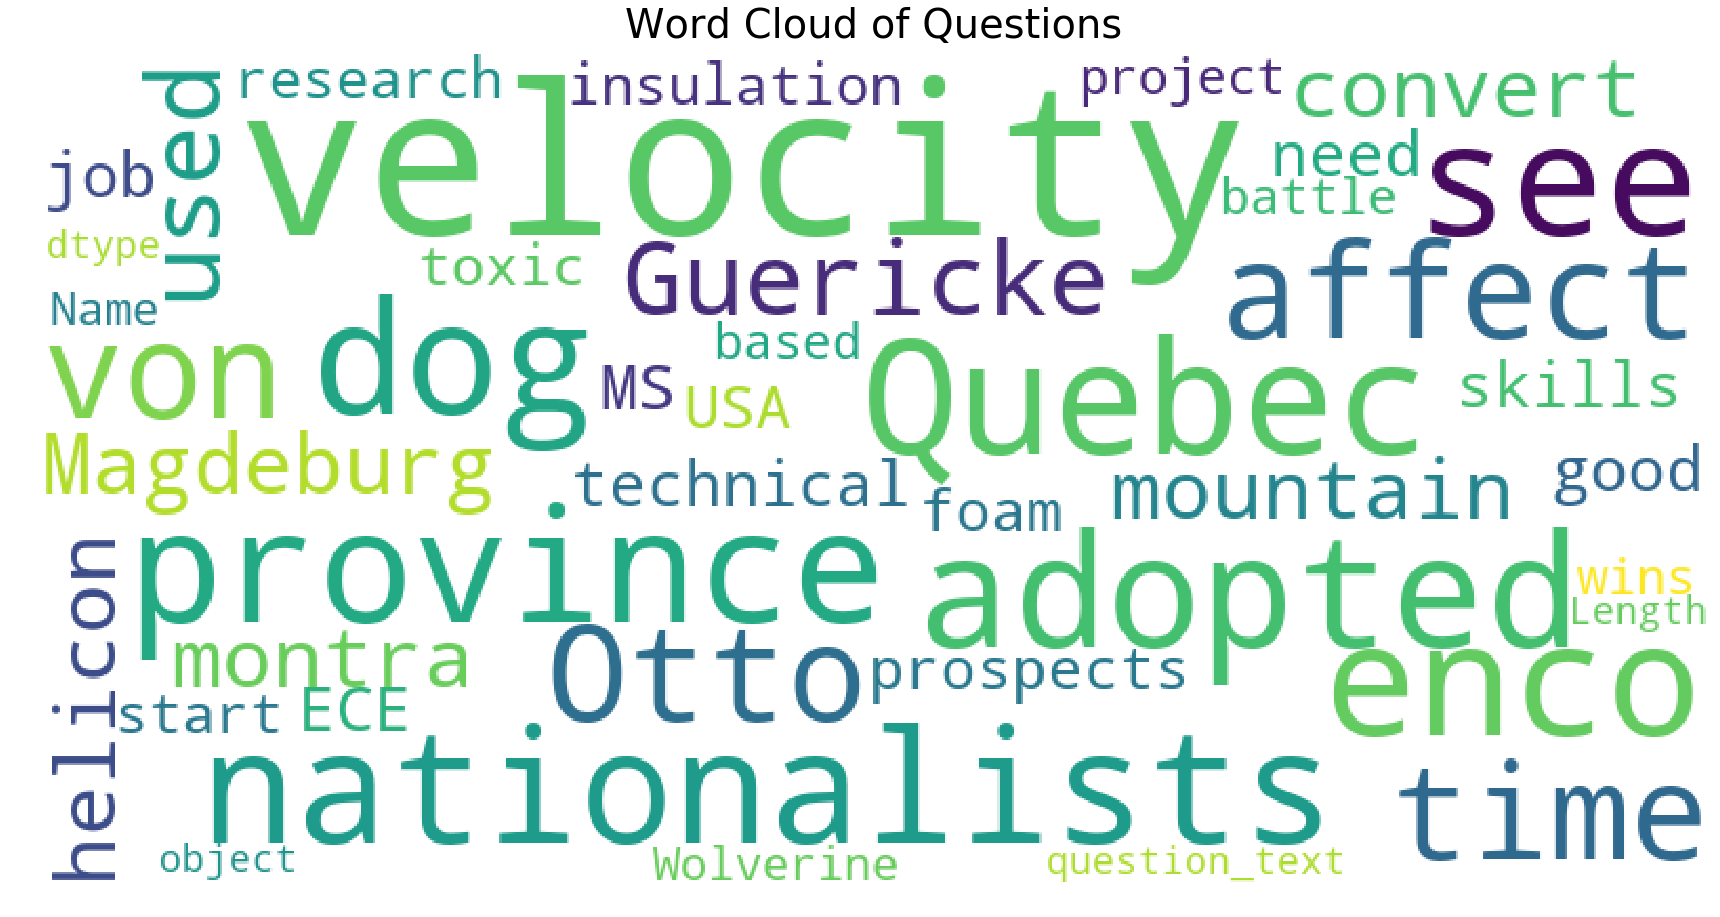

In [8]:
from wordcloud import WordCloud, STOPWORDS

# Thanks : https://www.kaggle.com/aashita/word-clouds-of-various-shapes ##
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_set["question_text"], title="Word Cloud of Questions")

Let's tokenize using the NLTK package

In [9]:
tokens_normal = train_set.query('target==0')['question_text'].apply(word_tokenize)
tokens_insincere = train_set.query('target==1')['question_text'].apply(word_tokenize)

In [10]:
stopword_list = set(stopwords.words('english'))

In [11]:
def eda_preprocess(words):
    # Remove single-character and 2 character tokens (mostly punctuation)
    words = [word for word in words if len(word) > 2]

    # Remove numbers
    words = [word for word in words if not word.isnumeric()]

    # Lowercase all words (default_stopwords are lowercase too)
    words = [word.lower() for word in words]

    # Remove stopwords
    words = [word for word in words if word not in stopword_list]
    
    return words
    

In [12]:
tokens_normal = tokens_normal.apply(eda_preprocess)
tokens_insincere = tokens_insincere.apply(eda_preprocess)

In [13]:
frequencies = Counter(word for sentence in tokens_normal for word in sentence)
for word, frequency in frequencies.most_common(30):  # get the 10 most frequent words
    print(word, frequency)

best 61636
get 59445
would 58072
people 43397
like 43133
n't 38060
good 36812
one 32240
india 29349
make 26233
time 22197
think 22145
someone 21846
much 21463
life 21361
many 20919
use 20746
way 19732
know 18481
work 18111
take 17339
ever 16733
find 16601
want 16373
could 15886
become 15864
without 15841
person 15672
better 14947
world 14662


Looks like the normal quora questions use the usual common words in the English language. And of course India is very common, since many quora users are Indian.

In [14]:
frequencies = Counter(word for sentence in tokens_insincere for word in sentence)
for word, frequency in frequencies.most_common(30):  
    print(word, frequency)

people 12952
n't 8324
trump 6465
like 5962
women 5959
would 4325
men 4216
think 3887
white 3713
many 3571
muslims 3492
quora 3407
india 3291
get 3226
indian 3133
black 2939
americans 2916
sex 2557
indians 2508
girls 2507
world 2462
want 2416
hate 2236
liberals 2097
chinese 2089
much 1974
make 1963
country 1933
muslim 1903
one 1816


On the other hand, insincere questions repeat controversial topics like Trump, gender, muslims, race and sex. By far everyone seems to be asking about controversial people or groups of people

* How long are most sentences? We'll just count the tokenised versions

In [15]:
def count_sentences(tokens):
    length=[]
    for sent in tokens:
        length.append(len(sent))
    
    return length

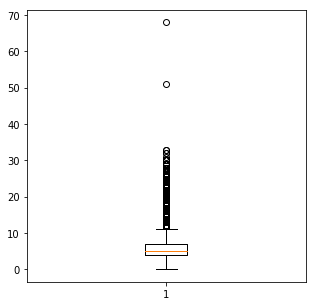

In [16]:
fig,ax = plt.subplots(figsize=(5,5))
plt.boxplot(count_sentences(tokens_normal))
plt.show()

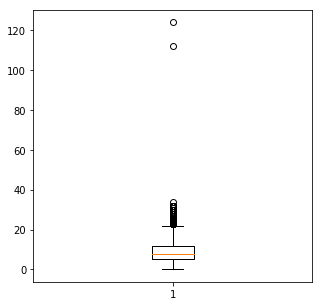

In [17]:
fig,ax = plt.subplots(figsize=(5,5))
plt.boxplot(count_sentences(tokens_insincere))
plt.show()

The insincere questions on average are longer. Perhaps people spamming and repeating same words over and over.

In [18]:
from statistics import median 
print(median(count_sentences(tokens_insincere)))
print(median(count_sentences(tokens_normal)))

8.0
5.0


## Pre-Processing for Baseline <a></a>

In [19]:
# Removes punctuation
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [20]:
train_text = train_set['question_text']
test_text = test_set['question_text']
train_target = train_set['target']

## Modelling

In [21]:
tfidf_vectoriser = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode')
train_tfidf = tfidf_vectoriser.fit_transform(train_text)
test_tfidf = tfidf_vectoriser.transform(test_text)

In [22]:
classifier = LogisticRegression().fit(train_tfidf,train_target)
y_pred = classifier.predict(test_tfidf)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [23]:
y_pred

array([1, 0, 0, ..., 0, 0, 0])

In [24]:
submit_df = pd.DataFrame({"qid": test_set["qid"], "prediction": y_pred})
submit_df.to_csv("submission.csv", index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Leaderboard score ~0.56 for both SVM and LogisticReg (default params)